In [1]:
import argparse
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
import numpy as np 

from preprocess import get_mnist, get_webcam
from train import TrainerVaDE

In [2]:
class Args:
    batch_size = 128
    dataset = 'webcam'
    pretrained_path = 'weights/pretrained_parameter.pth'


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


args = Args() # Parsing all the arguments for the training
if args.dataset == 'mnist':
    dataloader_train, dataloader_test = get_mnist(args)
    n_classes = 10
else:
    dataloader_train, dataloader_test = get_webcam(args)
    n_classes = 31

In [3]:
if args.dataset == 'webcam':
    from models_office import Autoencoder, feature_extractor, VaDE
    VaDE = VaDE().to(device)
    autoencoder = Autoencoder().to(device)
    autoencoder.load_state_dict(torch.load('weights/autoencoder_parameters.pth.tar',
                                    map_location=device)['state_dict'])
    
    checkpoint = torch.load('weights/feature_extractor_params.pth.tar',
                             map_location=device)
    feature_extractor = feature_extractor().to(device)
    feature_extractor.load_state_dict(checkpoint['state_dict'])
    
elif args.dataset == 'mnist':
    from models import Autoencoder, VaDE
    VaDE = VaDE().to(device)
    autoencoder = Autoencoder().to(device)
    autoencoder.load_state_dict(torch.load('weights/autoencoder_parameters.pth.tar',
                                    map_location=device)['state_dict'])

In [13]:
import numpy as np 


if args.dataset == 'webcam':
    classes = ['back_pack',
                'bike',
                'bike_helmet',
                'bookcase',
                'bottle',
                'calculator',
                'desk_chair',
                'desk_lamp',
                'desktop_computer',
                'file_cabinet',
                'headphones',
                'keyboard',
                'laptop_computer',
                'letter_tray',
                'mobile_phone',
                'monitor',
                'mouse',
                'mug',
                'paper_notebook',
                'pen',
                'phone',
                'printer',
                'projector',
                'punchers',
                'ring_binder',
                'ruler',
                'scissors',
                'speaker',
                'stapler',
                'tape_dispenser',
                'trash_can']
else:
    classes = ['0',
               '1',
               '2',
               '3',
               '4',
               '5',
               '6',
               '7',
               '8',
               '9']


def get_latent_space(dataloader, z_dim, model, device, ftr_ext=None):
    z = torch.zeros((1, z_dim)).float().to(device)
    y = torch.zeros((1)).long().to(device)
    with torch.no_grad():
        for img, label in dataloader:
            img, label = img.to(device).float(), label.to(device).long()
            if ftr_ext is not None:
                img = ftr_ext(img); img = img.detach()

            z_l = model.encode(img)
            y = torch.cat((y, label), dim=0)
            z = torch.cat((z, z_l), dim=0)
    return z[1:], y[1:]


def plot_tsne(X_embedded, y, ticks):
    f, ax1 = plt.subplots(1, 1, sharey=True, figsize=(15,10))

    cmap = plt.get_cmap('jet', 31)


    cax = ax1.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y.numpy(),
                      s=15, cmap=cmap)

    cbar = f.colorbar(cax, ticks=np.linspace(0,30,31))
    cbar.ax.set_yticklabels(ticks)

    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)

    plt.show()

In [14]:
z_dim = 10

z, y = get_latent_space(dataloader_train, z_dim, autoencoder, device, feature_extractor)
z, y = z.cpu(), y.cpu()
z_embedded = TSNE(n_components=2).fit_transform(z.detach().numpy())

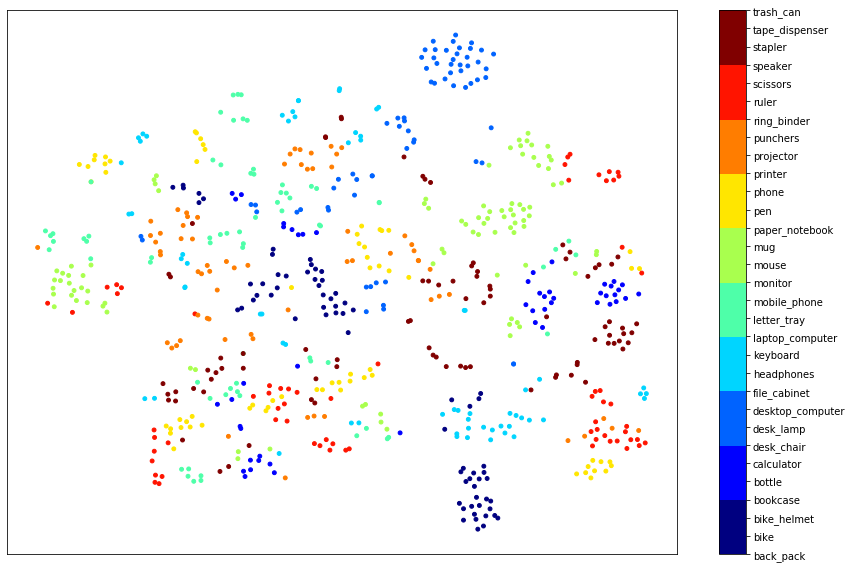

In [15]:
plot_tsne(z_embedded, y, classes)

In [7]:
means = []
var = []
proportion = []
for i in range(n_classes):
    ixs = np.where(y.cpu().numpy() == i)
    means.append(torch.mean(z[ixs].detach(), dim=0))
    var.append(torch.std(z[ixs].detach(), dim=0)**2)
    proportion.append(len(ixs))

In [8]:
means = torch.stack(means)
means

tensor([[-4.5071e+00, -1.5645e+01,  1.8312e+00,  2.7306e+01,  1.3661e+01,
         -3.7745e+00, -1.0619e+00,  1.9737e+01, -3.7002e+00, -6.6246e-01],
        [-2.3897e+01, -1.2104e+00,  2.7552e+00,  2.9344e+00, -4.5011e+00,
         -7.3391e+00, -1.0434e+01,  2.7530e+01,  2.4869e+00,  3.0298e+00],
        [-1.6167e+01, -2.3787e+00, -5.4135e+00,  5.8640e+00,  2.1817e+00,
         -6.2850e+00,  1.0009e+01,  1.8077e+01,  1.7405e+01,  3.5545e-01],
        [-8.4726e+00,  1.4355e+00, -1.7839e+00, -3.3326e+00, -1.8385e+01,
         -1.2937e+01, -1.3850e+00,  2.4965e+01,  1.7704e+01,  1.1339e+01],
        [-9.7184e-01, -5.7175e+00, -1.3444e+01,  1.1527e+01,  2.5834e+01,
         -9.6791e+00,  1.2825e+00, -4.7762e+00,  1.0365e+01, -4.2517e+00],
        [ 1.9390e+00,  2.4677e+00, -9.1891e+00,  6.9029e+00,  7.8071e+00,
          3.4145e+00,  5.7854e+00,  1.3492e+01,  1.4585e+01, -1.0608e+00],
        [-1.3194e+01, -1.0473e+01, -2.1742e+00,  7.7442e+00, -6.6203e-01,
         -1.9582e+01, -1.2276e+0

In [9]:
var = torch.stack(var)
var

tensor([[ 38.0074,  47.5833,  90.8328,  27.5001,  22.3178,  39.9533,  33.5709,
          47.9043,  56.6876,  33.3708],
        [ 15.6729,  88.3132,  32.0959,  54.1982,  58.7588,  33.8457,  82.1543,
          60.1682, 100.2473,  52.7686],
        [ 33.9024,  54.0101,  35.9014,  42.5409,  80.9777,  40.1828,  55.2124,
         122.5148,  45.0095,  49.6150],
        [  8.5573,  95.0934,  25.7794,  39.3084,  34.3482,   9.8501,  58.8561,
          58.4077,  19.5995,  61.4385],
        [ 18.2439,  19.9920,  29.8549,  28.0751,  20.8912,  15.3704,  22.2431,
           8.4759,  16.2605,  20.3715],
        [214.2691,  94.3687,  58.4762,  25.4140,  68.6180, 128.6739,  73.6071,
          83.1587,  39.0755, 146.6407],
        [ 28.2422,  36.0388,  67.5132,  32.7427,  79.8585,  37.3653,  24.7010,
          37.8944,  62.5076, 135.6947],
        [ 49.3303,  55.8124,  47.0538, 159.7351, 142.1525,  35.8908,  26.1427,
          69.6743,  61.7334,  34.9688],
        [ 20.2464,  72.3839, 128.6123,  33.8343,

In [10]:
proportion = torch.Tensor(proportion)/torch.sum(torch.Tensor(proportion))
proportion

tensor([0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323,
        0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323,
        0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323,
        0.0323, 0.0323, 0.0323, 0.0323])

In [11]:
state_dict = autoencoder.state_dict()

VaDE.load_state_dict(state_dict=state_dict, strict=False)
VaDE.pi_prior.data = proportion.float().to(device)
VaDE.mu_prior.data = means.float().to(device)
VaDE.log_var_prior.data = torch.log(var).float().to(device)
torch.save(VaDE.state_dict(), args.pretrained_path) 

In [12]:
proportion

tensor([0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323,
        0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323,
        0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323, 0.0323,
        0.0323, 0.0323, 0.0323, 0.0323])